In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import pymc_bart as pmb

In [2]:
az.style.use('arviz-doc')
RANDOM_SEED = 5781

In [3]:
%%HTML
<style>

.CodeMirror {
    width: 100vw;
}

.container {
    width: 99% !important;
}

.rendered_html {
  font-size:0.8em;
}
.rendered_html table, .rendered_html th, .rendered_html tr, .rendered_html td {
     font-size: 100%;
}


body {
  font-family: Ubuntu;
  background: #F0F0F0;
  background-color: #F0F0F0;
}


.reveal h1,
.reveal h2,
.reveal h3,
.reveal h4,
.reveal h5,
.reveal h6 {
  margin: 0 0 20px 0;
  color: #2a2eec;
  font-family: Ubuntu;
  line-height: 0.9em;
  letter-spacing: 0.02em;
  text-transform: none;
  text-shadow: none;
}

.reveal blockquote {
  display: block;
  position: relative;
  background: #fa7c17;
  border-radius: 15px;
  box-shadow: 0px 0px 2px rgba(0, 0, 0, 0.2);
  font-weight: bold;
}

</style>

In [4]:
from traitlets.config.manager import BaseJSONConfigManager
path = "/home/osvaldo/anaconda3/etc/jupyter/nbconfig"
cm = BaseJSONConfigManager(config_dir=path)
cm.update("livereveal", {
              "theme": "serif",
              "transition": "zoom",
              "start_slideshow_at": "selected",
              "controls": "True",
              "progress": "False",
              "shortcut": "False"});

<center><img src="img/Logo_UNSAM.png" width="200"></center>
<br>
<br>
<h1 align="center">Árboles de regresión aditivos Bayesianos</h1>    


<br>
<br>
<br>
<br>
<br>

## Objetivos

<br>

* Árboles de decisión
* Modelos BART
* Regresión flexible con BART
* Gráficos de dependencia parcial
* Selección de variables

## Funciones no-lineales

<br>
Vimos que podíamos excribir GLMs como:

$$
\begin{aligned}
\mu &= \alpha + \beta X \\
Y &\sim \phi(L(\mu), \theta)
\end{aligned}
$$

* El objetivo de este capítulo es generar modelos de la forma de:

$$
\begin{aligned}
\mu &= f(X) \\
Y &\sim \phi(L(\mu), \theta)
\end{aligned}
$$

donde $f$ es una función que aproximamos de forma no paramétrica.
<br>


## Árboles vs GPs

<br>

* Anteriormente vimos que era posible modelar funciones usando GPs como priors
* Ahora vamos a ver una alternativa basada en árboles

<br>

## Árboles de decisión

<br>


* Informalmente podemos pensar un árbol como un diagrama de flujo
* Empezamos siempre desde la "raíz" y vamos contestando una serie de pregunta del tipo si/no
* Eventualmente alcanzaremos una "hoja" que tendrá la respuesta a nuestro problema.

<br>


## Árboles formales

<br>

* Un poco más formal podemos decir que:
    * Un árbol es un conjunto de nodos y lados, es decir un gráfo.
    * Los árboles NO tiene ciclos, de forma que cualquier par de nodos está conectado por un único camino.
    * El nodo raiz NO tiene padres
    * Los nodos hoja NO tienen hijos 
    * Un árbol binario es aquel en donde cualquier nodo no tiene más de dos hijos 
        * A veces se define como cada nodo no-hoja tiene exactamente dos hijos

<br>

## Árboles de decisión

<br>
Supongamos que tenemos dos variables $X_1$ y $X_2$ y queremos usar esas variables para clasificar objetos en dos clases: ⬤ o ▲. 

<br>

<center><img src="../img/decision_tree_00.png" width="300"></center>


## Árboles de decisión

<br>

* Las variables $X_1$ e $X_2$ definen un plano
* Un arbol de decision divide en plano en regiones "rectangulares"
* Los limites de cada región están definidos por segmentos paralelos a los ejes de coordenadas.

<br>

<center><img src="../img/decision_tree.png" width="700"></center>

## Árboles de regresión

<br>
<br>

* Cuando los valores de los nodos hojas son clases --> árboles de decisión
* Cuando los valores de los nodos hojas son reales --> árboles de regresión
* En la práctica es común tener combinaciones

<br>
<br>


<center><img src="../img/decision_tree_reg.png" width="700"></center>

## Árboles y splines

<br>
<br>

* Vimos que con los splines podíamos definir una función como una suma pesada de funciones base.
* Para ellos utilizamos un tipo particular de polinomio definidos/restringidos utilizando un conjunto de nudos.
* Si restringuimos los polinomios a orden 0, es decir constantes, los splines y los árboles son equivalentes.
<br>
<br>

![](../img/splines_weighted.png)

## Árboles y splines

<br>
<br>

* La diferencia está en como se usan!
* Para los splines necesitamos definir los nudos de antemano, en los árboles podemos "aprenderlos"
* Por construcción los splines suelen estar limitados a pocas dimensiones (1, 2, 3, ...), los árboles no.

<br>
<br>

## Extrapolación

* Los árboles, como los que hemos visto, representan funciones escalonadas
* Esta función escalonada se "proyecta de forma constante" fuera del rango de los datos

<center><img src="../img/decision_tree_reg_ext.png" width="700"></center>

## Interpretabilidad y flexibilidad

<br>
<br>

* Una característica atractiva de los árboles es su interpretabilidad: literalmente se puede leer el árbol y seguir los pasos necesarios para resolver un determinado problema
* Los árboles pueden representar tanto efectos principales como interacciones. 
    * Cuando un árbol depende de una sola variable $X_0$, estamos representando un efecto principal
    * Cuando un árbol depende de más de una variable $X_0, X_1, \dots$ estamos representando una interacción. 
* Como la profundidad de los árboles es arbitraria, en principio podemos modelar interacciones de orden arbitrario
* En la práctica estimar una interacción requiere de más datos que estimar una efecto principal y estimar una interacción de bajo orden requiere menos datos que una de mayor orden.

<br>

## Interpretabilidad y flexibilidad

<br>
<br>

* Los árboles son muy flexible, en principio es posible encontrar un árbol lo suficientemente complejo como para ajustar cualquier dataset.
* La contracara es el sobreajuste. 

<br>
<br>

![](../img/decision_tree_overfitting.png)

## Regularizando los árboles

<br>
<br>

* Es común introducir dispositivos para regularizar la complejidad de los árboles y disminuir el riesgo de sobreajuste 
* Una solución común es utilizar un conjunto de árboles y en vez de un solo árbol
* Cada árbol está restringido en uno o más aspectos, por ej la profundidad, de esa forma no puede sobreajustar
* Luego las constribuciones se combinan para genera una única respuesta, una posibildiad es sumarlas.

<br>
<br>

## Regularizando los árboles

<br>
<br>

* Estrictamente una suma de árboles es equivalente a un nuevo árbol más profundo.
* En principio sería posible trabajar con un solo árbol y encontrar una solución que no sobreajuste. Pero empiricamente esta tarea no es simple
* Una desventaja de utilizar conjuntos de árboles es que perdemos la interpretabilidad de un único árbol.
* Para obtener una respuesta no podemos seguir un solo árbol, debemos considerar a todos, lo que generalmente dificulta cualquier interpretación directa.
* Hemos cambiado la interpretabilidad por la flexibilidad y la generalización

<br>
<br>

## BART


De forma general podemos escribir un modelo BART como:


\begin{aligned}
\mu &= \sum_{j=0}^m G(\boldsymbol{X}; \mathcal{T}_i, \mathcal{M}_i)\\
Y &\sim \phi(L(\mu), \theta)
\end{aligned}

* $G$ representa una función-árbol parametrizada por 
    * $\mathcal{T}_i$, la estructucta del grafo junto con las reglas de decisión asociadas con los nodos internos
    * $\mathcal{M}_i$, el conjunto de valores de los nodos hojas.
* $\phi$ representa una distribución de probabilidad arbitraria que se usará como likelihood en nuestro modelo
* $\theta$ otros parámetros de $\phi$ no modelados como una suma de árboles.

## PyMC-BART

<br>

* PyMC-BART es una extensión de PyMC, que permite definir modelos con BART
* Tiene 3 componentes principales
    * Una "variable aleatoria" BART, esto es similar a como PyMC tienen un módulo que permite definir GPs
    * Un método de muestreo específico para árboles
    * Funciones auxiliares que facilitan analizar los resultados.

<br>

## Priors para BART

<br>

* En el [artículo original](https://arxiv.org/abs/0806.3286) de BART y en la mayoría de la literatura, los priors para BART son conjugados. En PyMC-BART no
* Para simplificar la especificación de los priors asumimos que la estructura del árbol $\mathcal{T}$ y los valores de las hojas $\mathcal{M}$ son independientes.
* Además estos priors son independientes de los priors para $\theta$. 

<br>

## Priors para BART

<br>
<br>

El prior para $\mathcal{T}$ se especifica como:

* La probabilidad de que un nodo de profundidad $d=(0, 1, 2, \dots)$ sea interno -->  $\alpha(1 + d)^{-\beta}$ con $\alpha \in (0, 1)$ y $\beta \in [0, \infty)$.
* La distribución sobre la variable de partición. Uniforme entre las covariables disponibles --> PyMC-BART lo ajusta durante la fase de tuning
* La distribución sobre los valores de partición. Uniforme sobre los valores disponibles.

<br>
<br>

## Priors para BART

<br>
<br>


El prior para los valores de las hojas $\mu_{ij}$


* Usamos $\mathcal{N}(\mu_\text{pred}, {\varepsilon^2})$, donde $\mu_\text{pred}$ se calcula como la media de la suma actual de árboles dividida por número de árboles $m$. 
* El valor inicial de $\varepsilon$ se calcula a partir de $Y$, siendo $\varepsilon = \frac{3}{\sqrt{m}}$ para datos binomiales y $\varepsilon = \frac{Y_\text{std}}{\sqrt{m}}$ para datos distintos del binomial, pero durante la fase de tuning se ajusta



<br>
<br>

## Priors para BART

<br>
<br>


* El número de árboles $m$ debe ser especificado, los valores comunmente usados suelen ser 50, 100 o 200.
* En principio se podría colocar un prior sobre $m$ pero en la práctica parece que nadie a encontrado una forma eficiente/correcta de hacerlo.
* Es posible usar validación cruzada para determinar $m$, también es posible usar LOO.

<br>
<br>

## Inferencia sobre árboles de regresión aditiva bayesiana

<br>

* Hasta ahora hemso discutido como especificar árboles, pero no como hacer inferencia.
* Para ajustar árboles no podemos usar métodos basados en gradientes como HMC

A grandes rasgos, cada paso del método implementado en PyMC-BART consiste en elegir uno de los $m_i$ árboles disponibles y proponer un nuevo árbol que lo reemplace. Para ello se procede de la siguiente forma:

1) Se hacen crecer $N$ árboles, comenzando desde la raíz y siguiendo los priors.
2) Se calcula un peso para cada uno de los $N$ árboles y para el árbol $m_i$
3) Se reemplaza el árbol $m_i$ por un árbol muestreado de forma proporcional a los pesos del punto 2

<br>

[Detalles](https://arxiv.org/abs/2206.03619)

## Inferencia sobre árboles de regresión aditiva bayesiana

<br>

* En este algoritmo los priors son utilizado como distribución de propuesta, esto no es lo más común.
* El peso calculado en el punto 2 es el log-likelihood, teniendo en cuenta la suma del árbol de propuesta y todos los demás árboles $m_{-i}$. 
* Siempre es posible elegir el árbol que se intenta reemplazar. Es decir es posible "quedarse en el lugar"
* Como sucede con métodos MCMC, la probabilidad de elegir un árbol que "empeore" el ajuste es no nula.

<br>

## Minería de carbón con BART

<br>

* Vamos a utilizar el mismo ejemplo que usamos con GPs
* Tenemos una sola columna de datos con las fechas
* Pre-procesamos los datos computando un histograma
    * Los centros de los bins serán nuestras X
    * Los conteos dentro de cada bin las Y.

<br>

In [5]:
coal = np.loadtxt("../datos/coal.csv")

In [6]:
# discretizar datos
years = int(coal.max() - coal.min())
bins = years // 4
hist, x_edges = np.histogram(coal, bins=bins)
# Calcular la ubicación de los centros de los datos discretizados
x_centers = x_edges[:-1] + (x_edges[1] - x_edges[0]) / 2
# x_data debe ser 2D para BART
x_data = x_centers[:, None]
# Expresar los datos como la tasa de número de accidentes por año
y_data = hist

In [7]:
with pm.Model() as modelo_coal:
    # BART Prior
    μ = pmb.BART("μ", X=x_data, Y=np.log(y_data), m=20)
    
    # likelihood
    y_pred = pm.Poisson("y_pred", mu=pm.math.exp(μ), observed=y_data)
    
    #sampling
    idata_coal = pm.sample(random_seed=RANDOM_SEED)

Multiprocess sampling (4 chains in 4 jobs)
PGBART: [μ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 12 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details


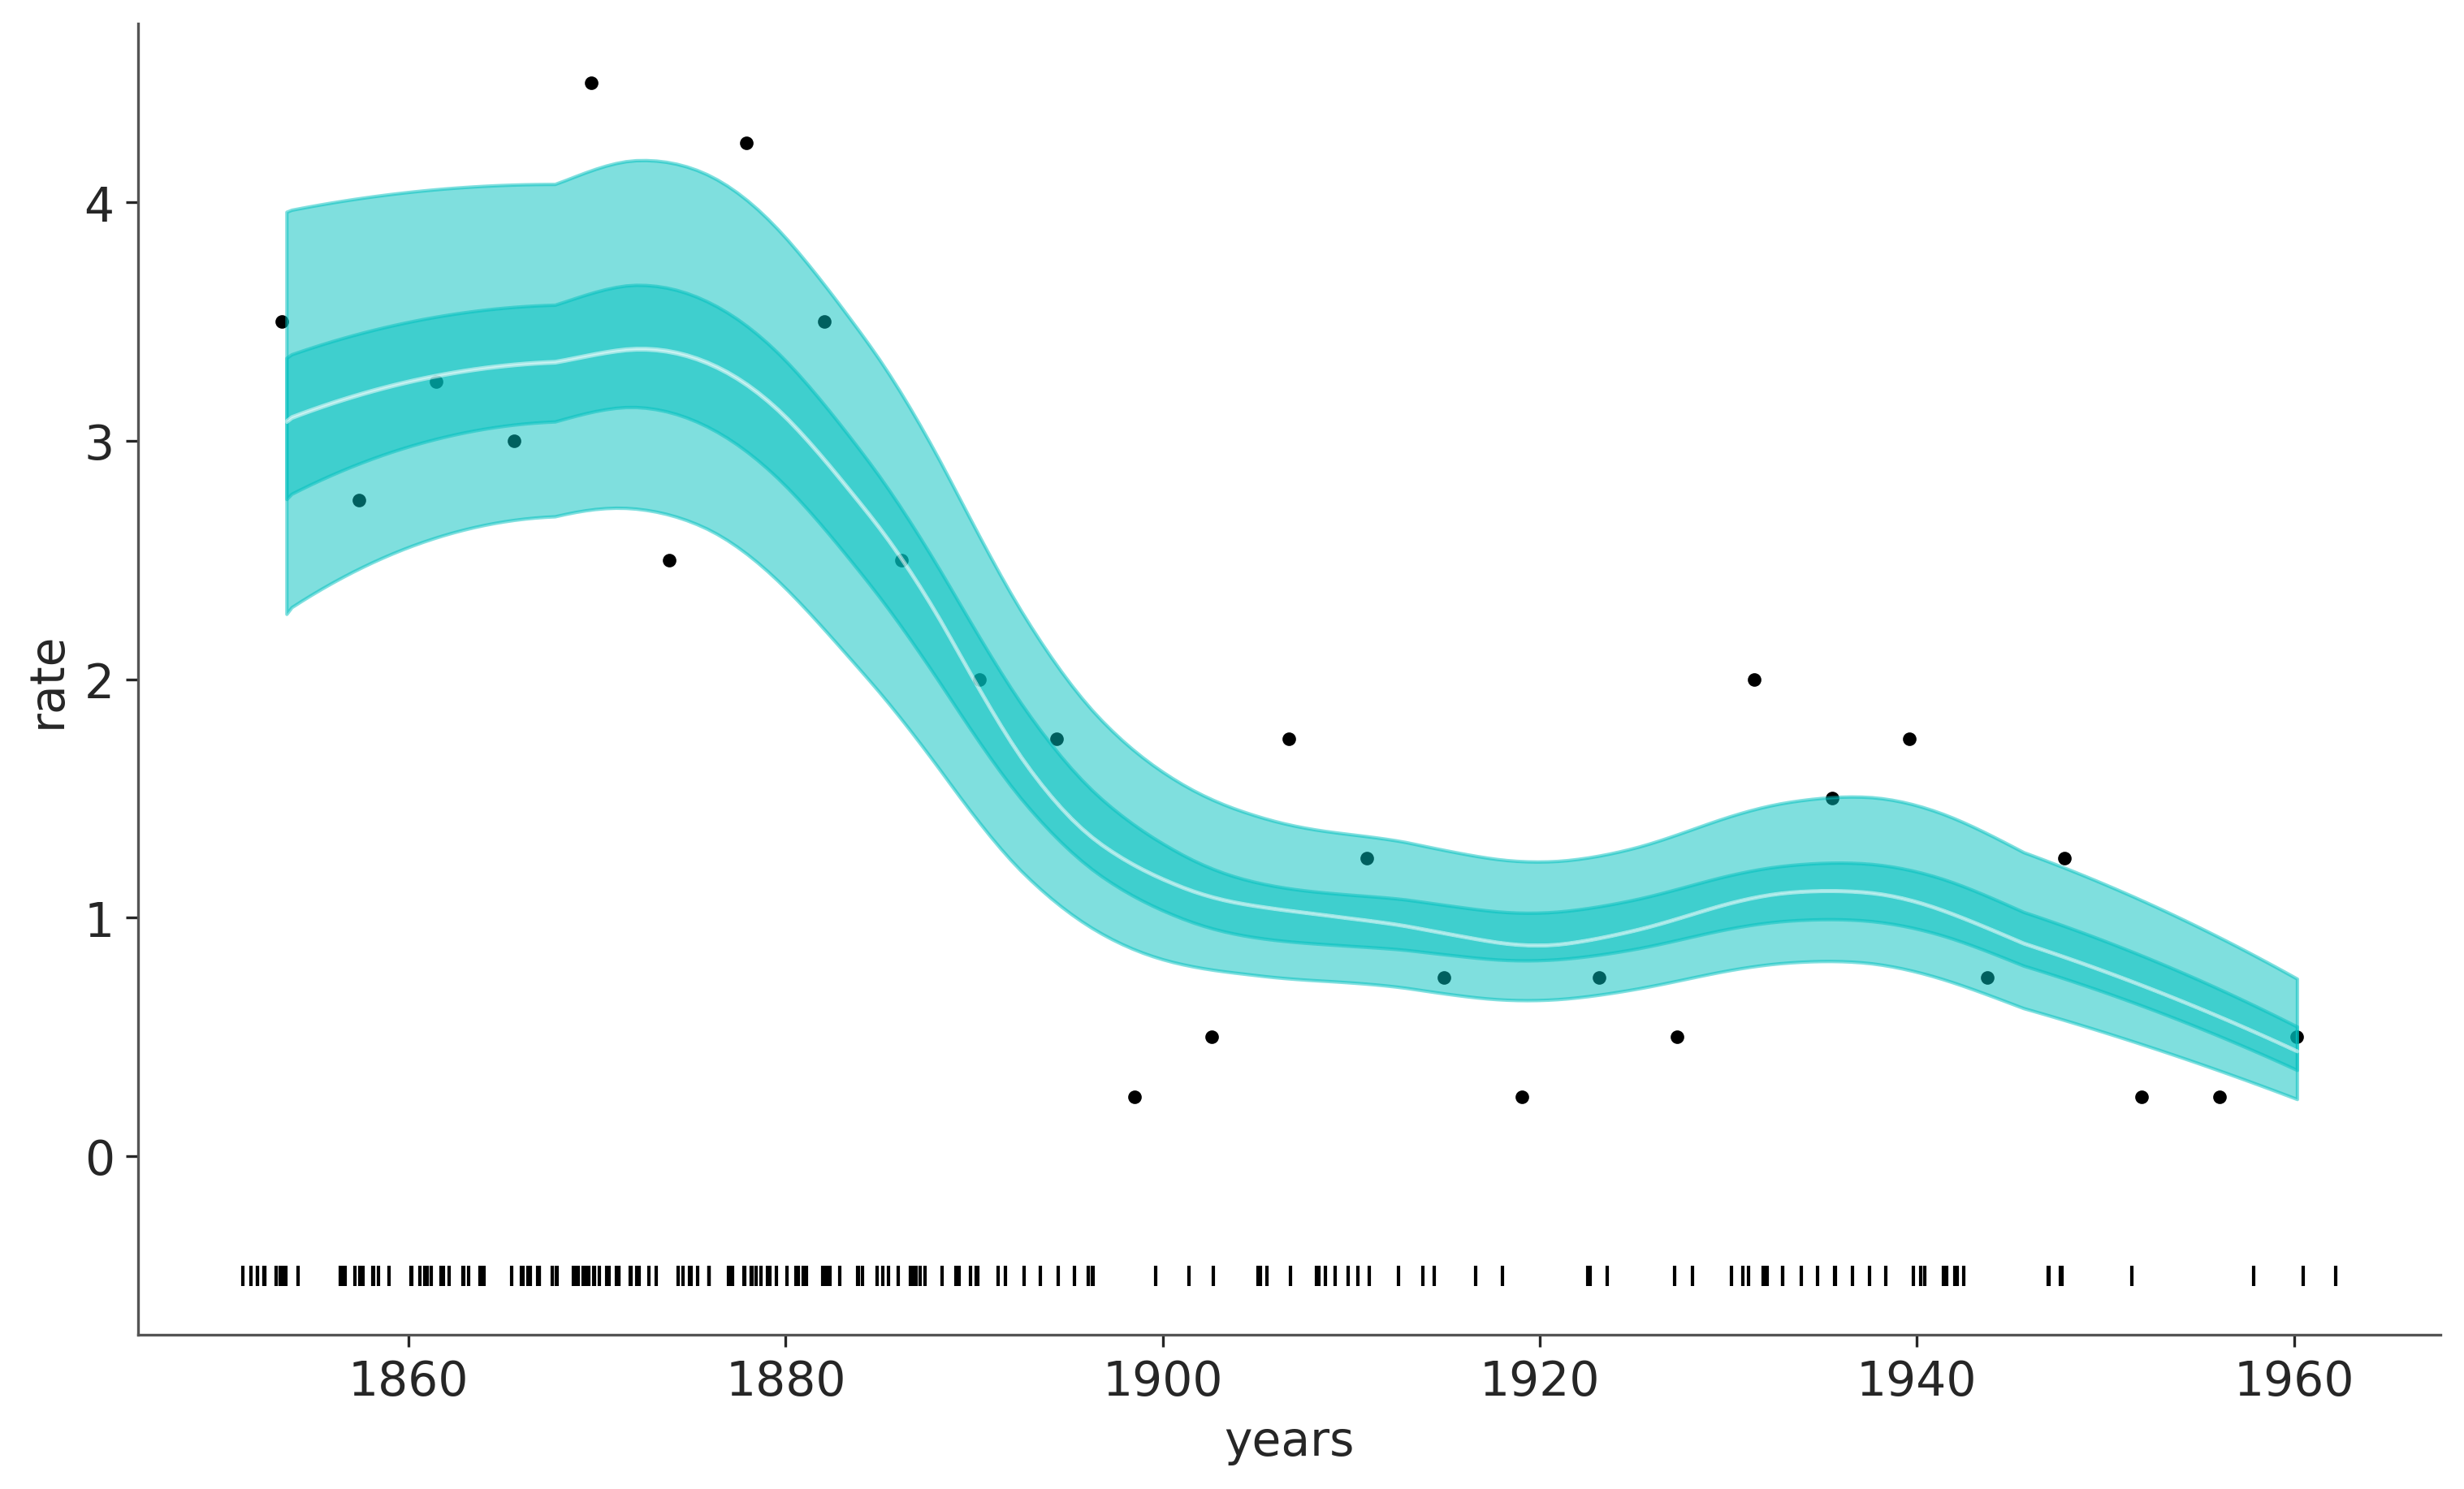

In [8]:
#| code-fold: true
_, ax = plt.subplots(figsize=(10, 6))

rates = np.exp(idata_coal.posterior["μ"]) / 4
rate_mean = rates.mean(dim=["draw", "chain"])
az.plot_hdi(x_centers, rates)
az.plot_hdi(x_centers, rates, hdi_prob=0.5, plot_kwargs={"alpha": 0})
az.plot_hdi(x_centers, rates, hdi_prob=0.01, color="w")
ax.plot(coal, np.zeros_like(coal) - 0.5, "k|")
ax.plot(x_centers, y_data / 4, "k.", zorder=-2)
ax.set_xlabel("years")
ax.set_ylabel("rate");

## Bicicleta BARTianas

<br>
<br>

* Vamos a volver a utilizar el dataset del alquiler de bicicletas

<br>
<br>

In [9]:
bicis = pd.read_csv("../datos/bicis.csv")

features = ["hora", "temperatura", "humedad", "viento"]

X = bicis[features]
Y = bicis["alquiladas"]

In [10]:
with pm.Model() as modelo_bicis:
    α = pm.Exponential("α", 1)
    μ = pmb.BART("μ", X, np.log(Y), m=50)
    
    y = pm.NegativeBinomial("y", mu=pm.math.exp(μ), alpha=α, observed=Y)
    
    idata_bicis = pm.sample(compute_convergence_checks=False, random_seed=RANDOM_SEED)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [α]
>PGBART: [μ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 49 seconds.


### Diagnóstico de convergencia

<br>

Para verificar la convergencia de muestreo de los modelos BART, recomendamos un enfoque de 2 pasos.

* Para las variables que no son BART (como $\alpha$ en `model_bicis`) seguimos las recomendaciones estándar, como verificar los diagnósticos numéricos R-hat (<= 1.01) y ESS (< 100x número de cadenas), así como trace-plots o rank-plots.
* En cambio para las variables BART recomendamos utilizar la función `pmb.plot_convergence
* El diagnóstico de modelos BART es un tema abierto, emiricamente se observa buenos ajustes incluso para modelos con "problemas" de convergencia.

<br>
<br>

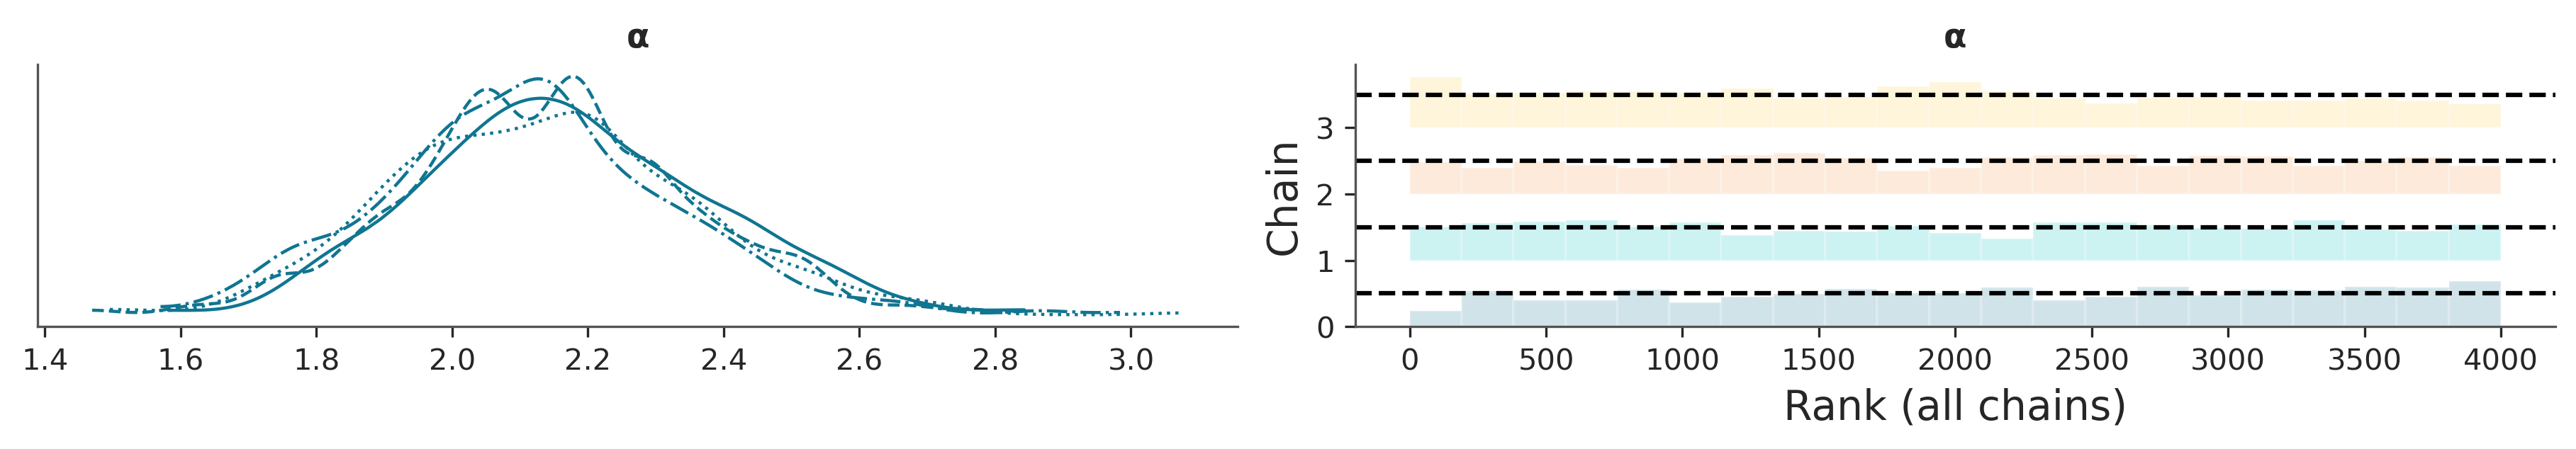

In [11]:
az.plot_trace(idata_bicis, var_names=["α"], kind="rank_bars");

/home/osvaldo/anaconda3/envs/EI2/lib/python3.11/site-packages/arviz/plots/ecdfplot.py:295: BehaviourChangeWarning: In future versions, if `eval_points` is not provided, then the ECDF will be evaluated at the unique values of the sample. To keep the current behavior, provide `eval_points` explicitly.
  warnings.warn(


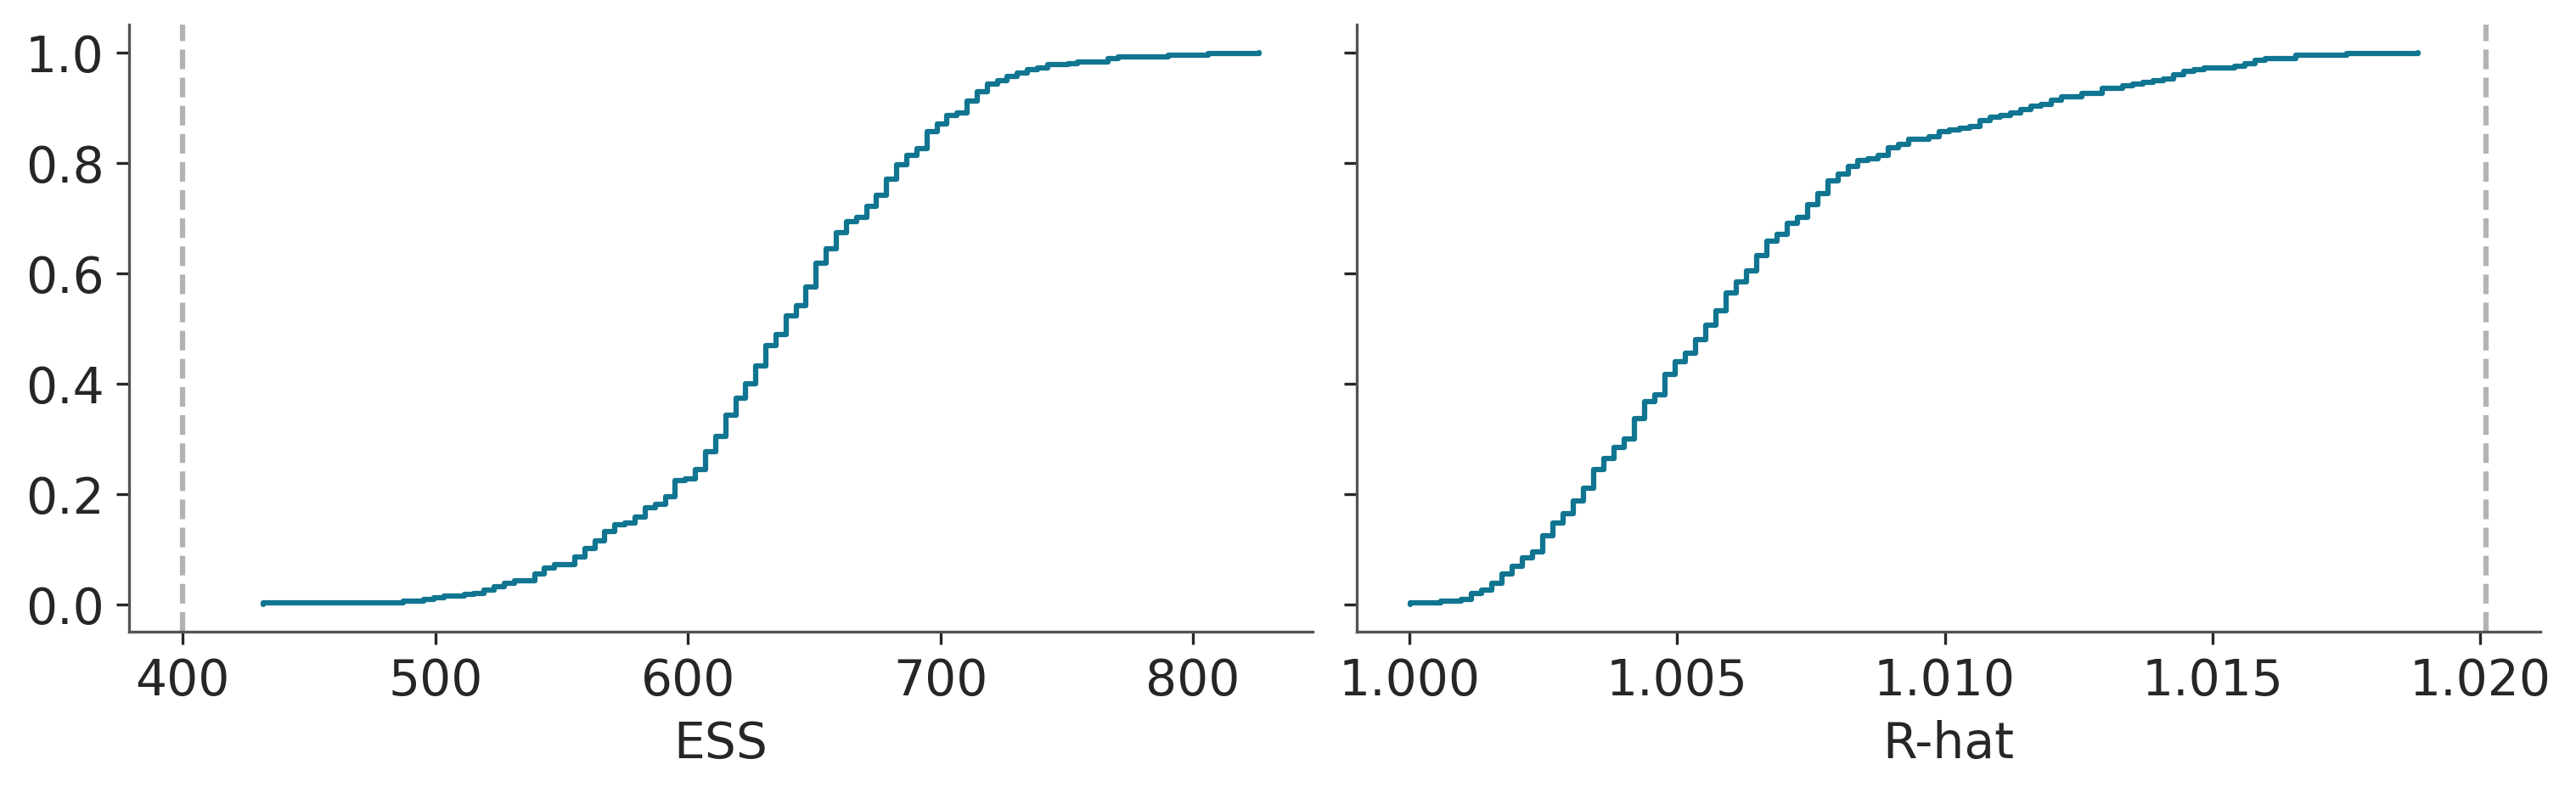

In [12]:
pmb.plot_convergence(idata_bicis, var_name="μ");

## Partial dependence plots

* Para ayudarnos a interpretar los resultados de nuestro modelo, utilizaremos gráficos de dependencia parcial. 

* Estos gráficos estiman la contribución de cada variable $X_i$ a la variable respuesta promediando los efectos de todas las demás variables ($X_j, \forall j \not = i$} 

* Si tuviesemos solo dos variabbles $X_0$ y $X_1$
$$
pd_{X_0}(x) \overset{def}{=} \mathbb{E}_{X_1}\left[ f(x, X_1) \right]
$$



* Este es un tipo de gráfico que muestra el efecto marginal que tiene una covariable sobre la variable predicha. Es decir, ¿cuál es el efecto que tiene una covariable $X_i$ sobre $Y$ mientras promediamos todas las demás covariables ($X_j, \forall j \not = i$). Esta herramienta no es exclusiva de BART. Pero se utilizan a menudo en la literatura de BART. 

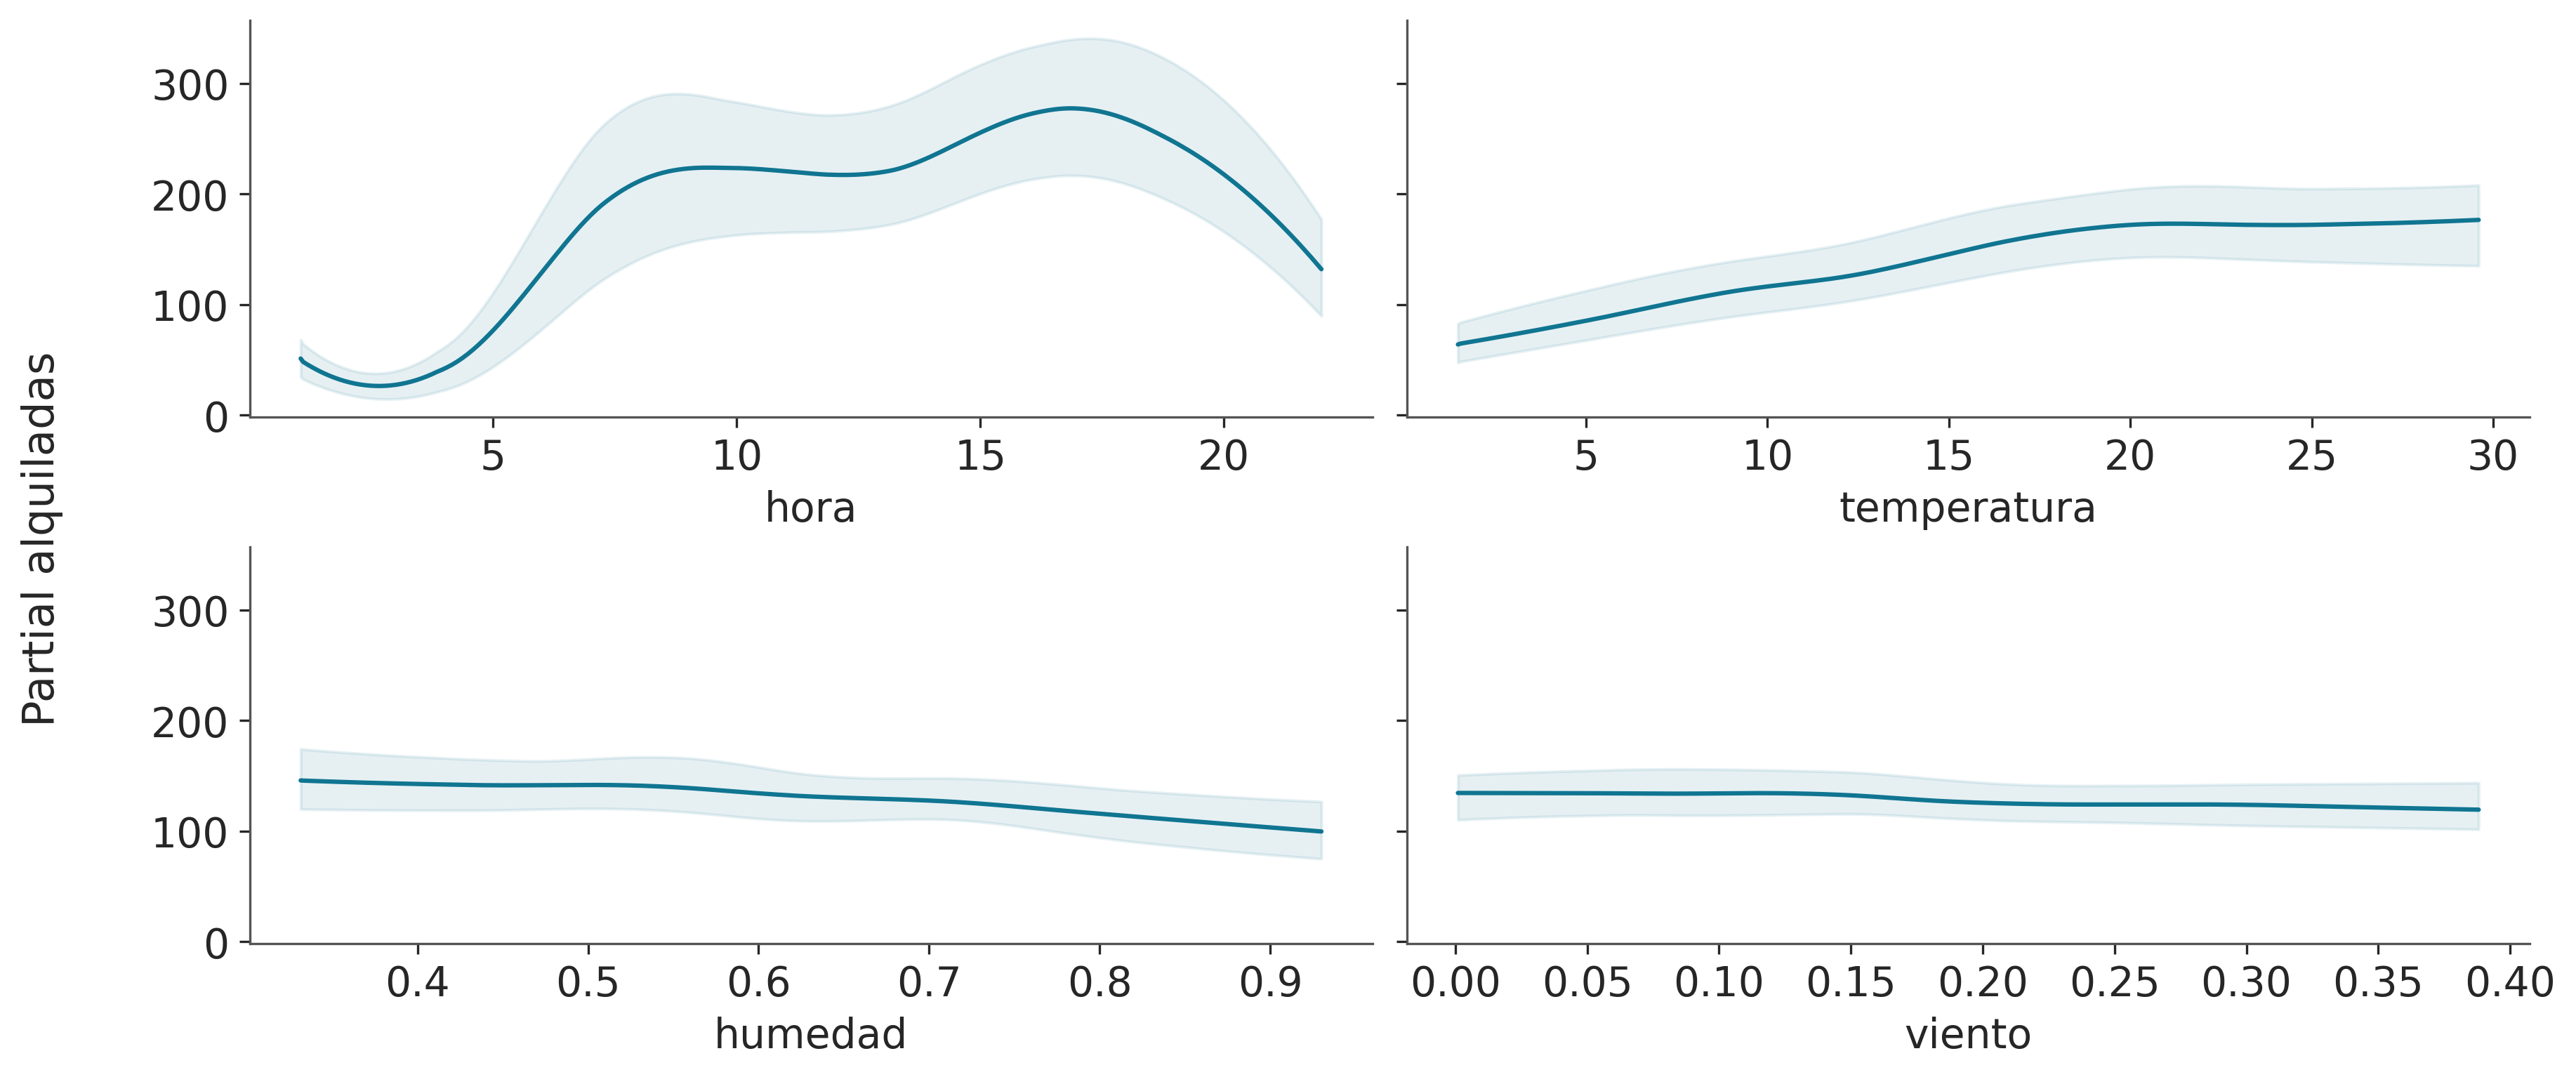

In [13]:
pmb.plot_pdp(μ, X=X, Y=Y, grid=(2, 2), func=np.exp);

### Selección de variables

<br>

* Los gráficos de dependencia parcial nos dan una idea de la contribución de cada variable, de su importancia relativa.

* Pero hay una forma más directa de estimar la importancia de las variables

* En la literatura de BART esto se hace evaluando la frecuencia relativa con que cada variable aparece en lo nodos de decisión de todos los árboles en la distribución a posteriori

* En PyMC-BART nosotros proponeos una alternativa

<br>

### Selección de variables

<br>

* Tomamos el modelo con todas las variables como referencia y generamos predicciones a partir de el
* Generamos submodelos 
* Comparamos las predicciones de los submodelos contra el modelo de referencia

* Este procedimiento es similar al visto en el capítulo de GLMs (kulprit)
* La diferencia es que con PyMC-BART, en vez de usar inferencia por proyección para calcular los submodelos, utilizamos "árboles podados"
    * Es decir aproximamos el efecto de eliminar una variable eliminando las ramas que contiene esa variable
    
<br>

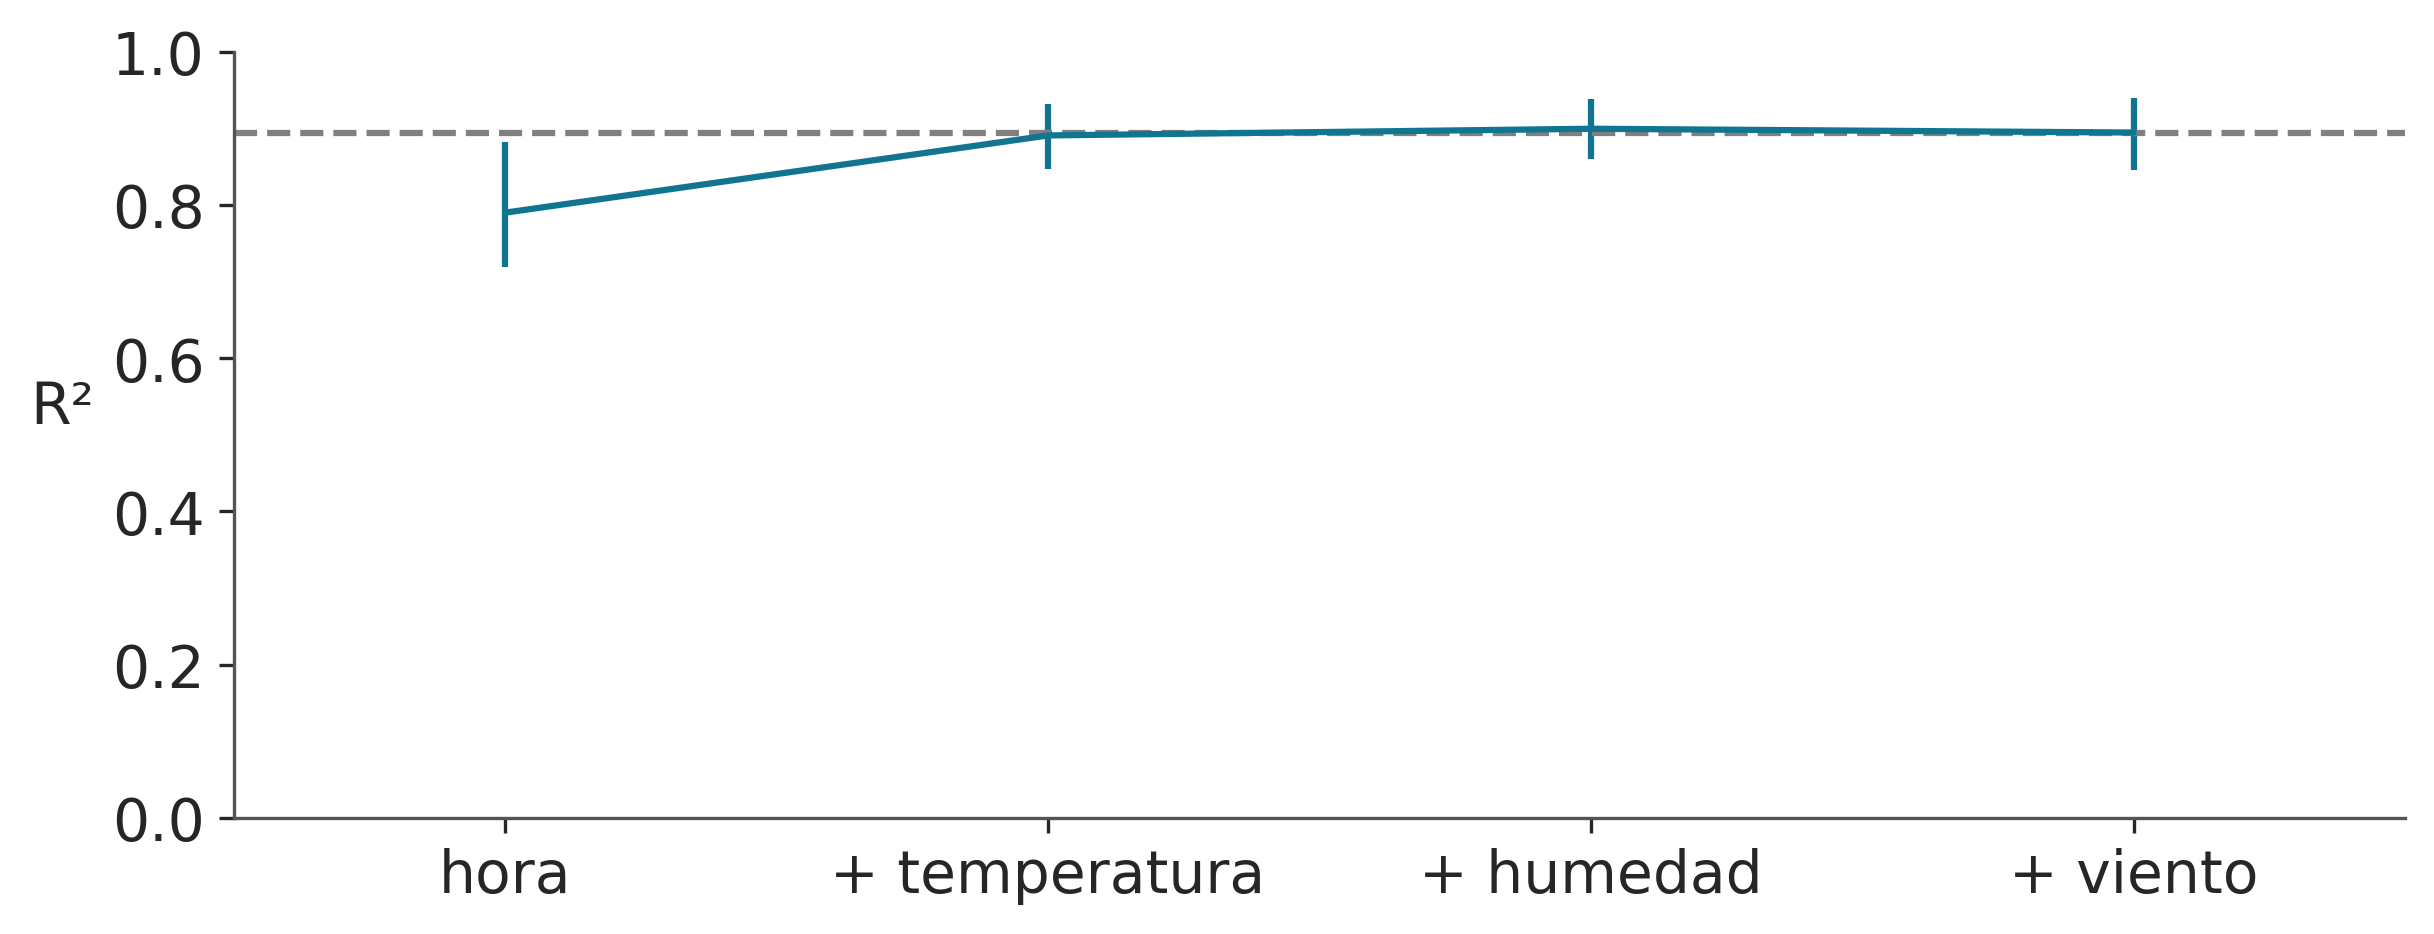

In [14]:
pmb.plot_variable_importance(idata_bicis, μ, X);

### Selección de variables

* Tenemos dos métodos para encontrar el orden de las variables

* "VI", contamos cuantas veces una variable aparece en los árboles a posteriori respecto de las demás
* "Backward", Comenzamos con el modelo de referencia y vamos eliminando la variable que menos contribuye al $R^2$.


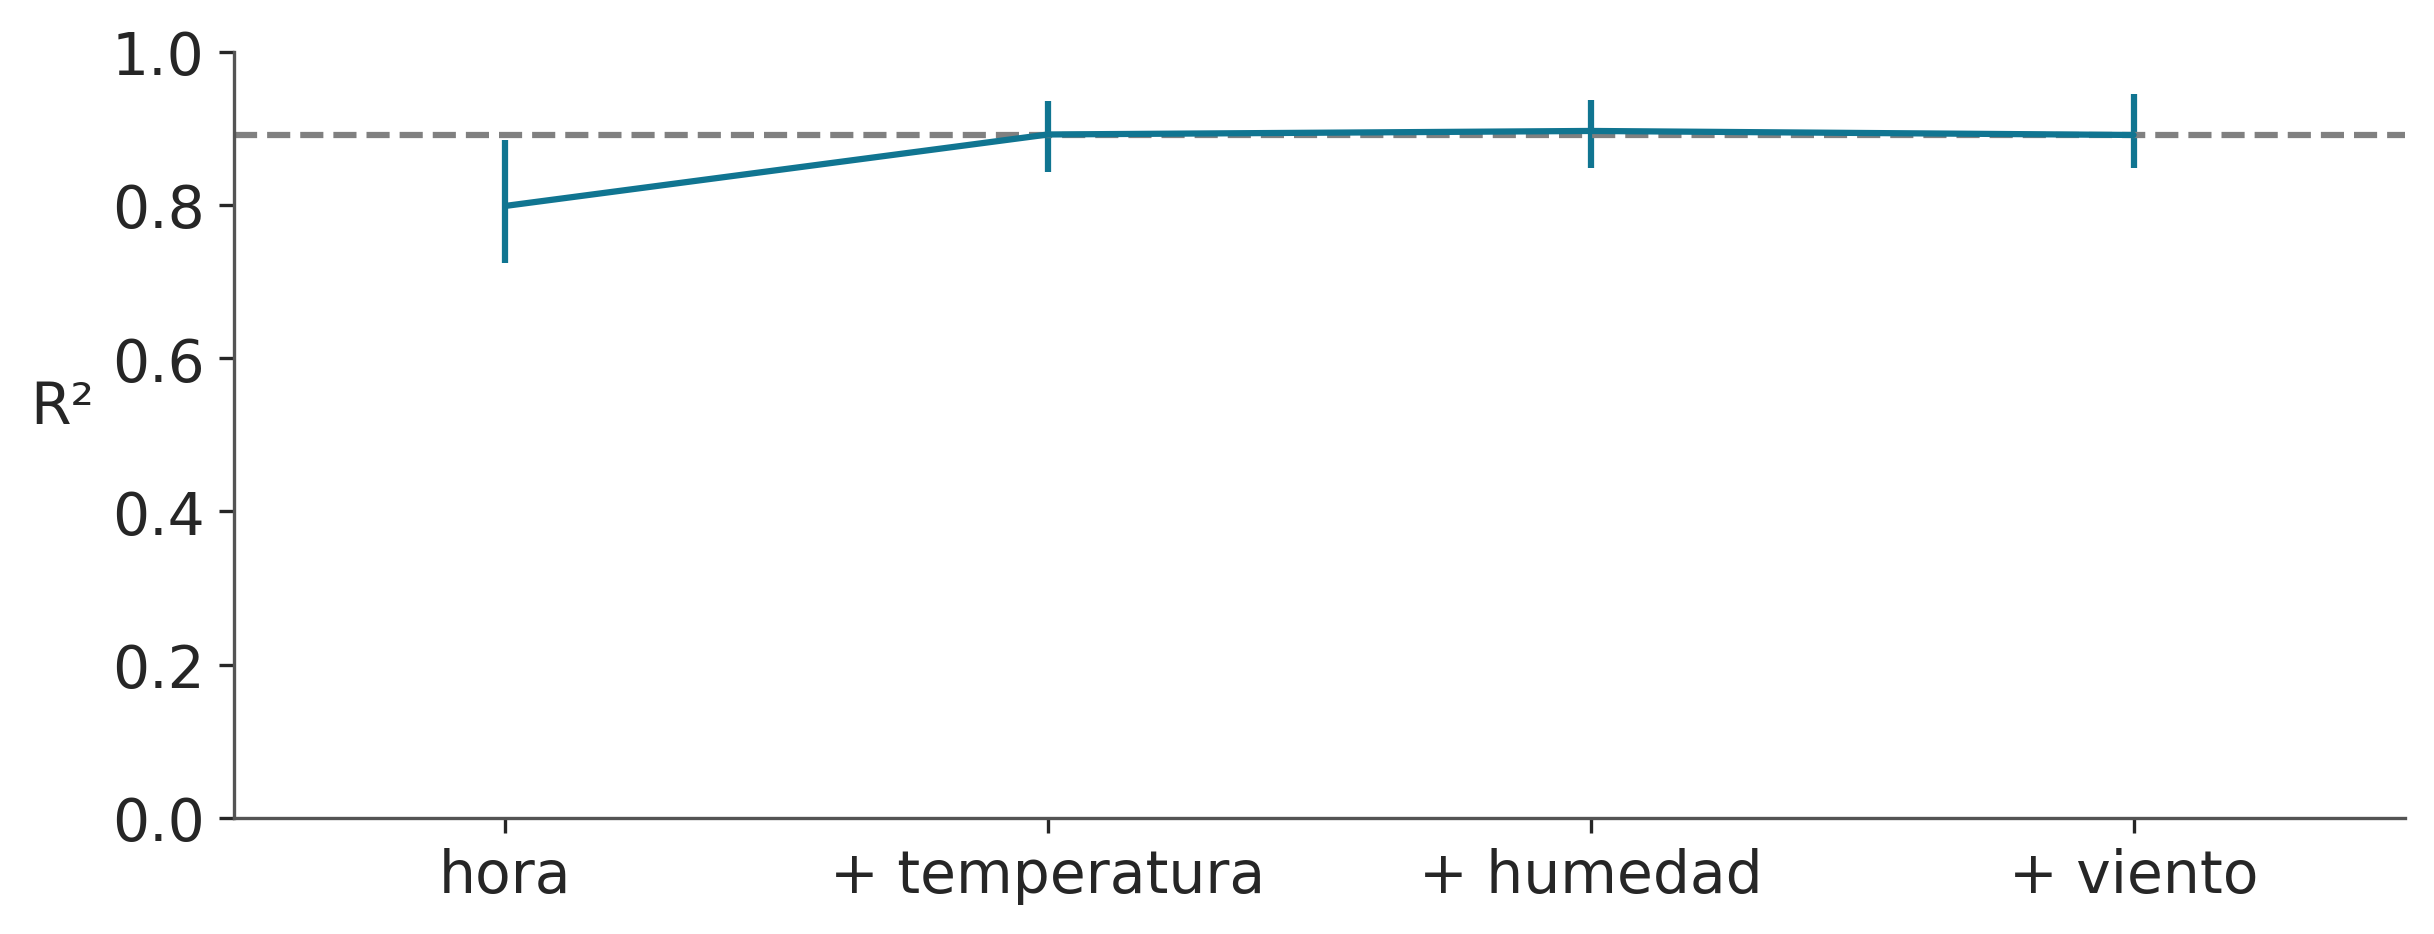

In [15]:
pmb.plot_variable_importance(idata_bicis, μ, X, method="backward");

## Modelos distribucionales con BART

<br>

* Con los GLMs vimos que si bien lo más común es estimar la media (o localización) podemos estimar TODOS los parámetros de una distribución.
* Estos modelos se los suele llamar distribucionales. 
* Podemos hacer lo mismo con BART

<br>

In [16]:
with pm.Model() as modelo_bb:
    μ = pmb.BART("μ", X, np.log(Y), shape=(2, 348), separate_trees=True)
    
    pm.NegativeBinomial('yl', mu=np.exp(μ[0]), alpha=np.exp(μ[1]), observed=Y)
    idata_bb = pm.sample(compute_convergence_checks=False, random_seed=RANDOM_SEED)

Multiprocess sampling (4 chains in 4 jobs)
PGBART: [μ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 103 seconds.


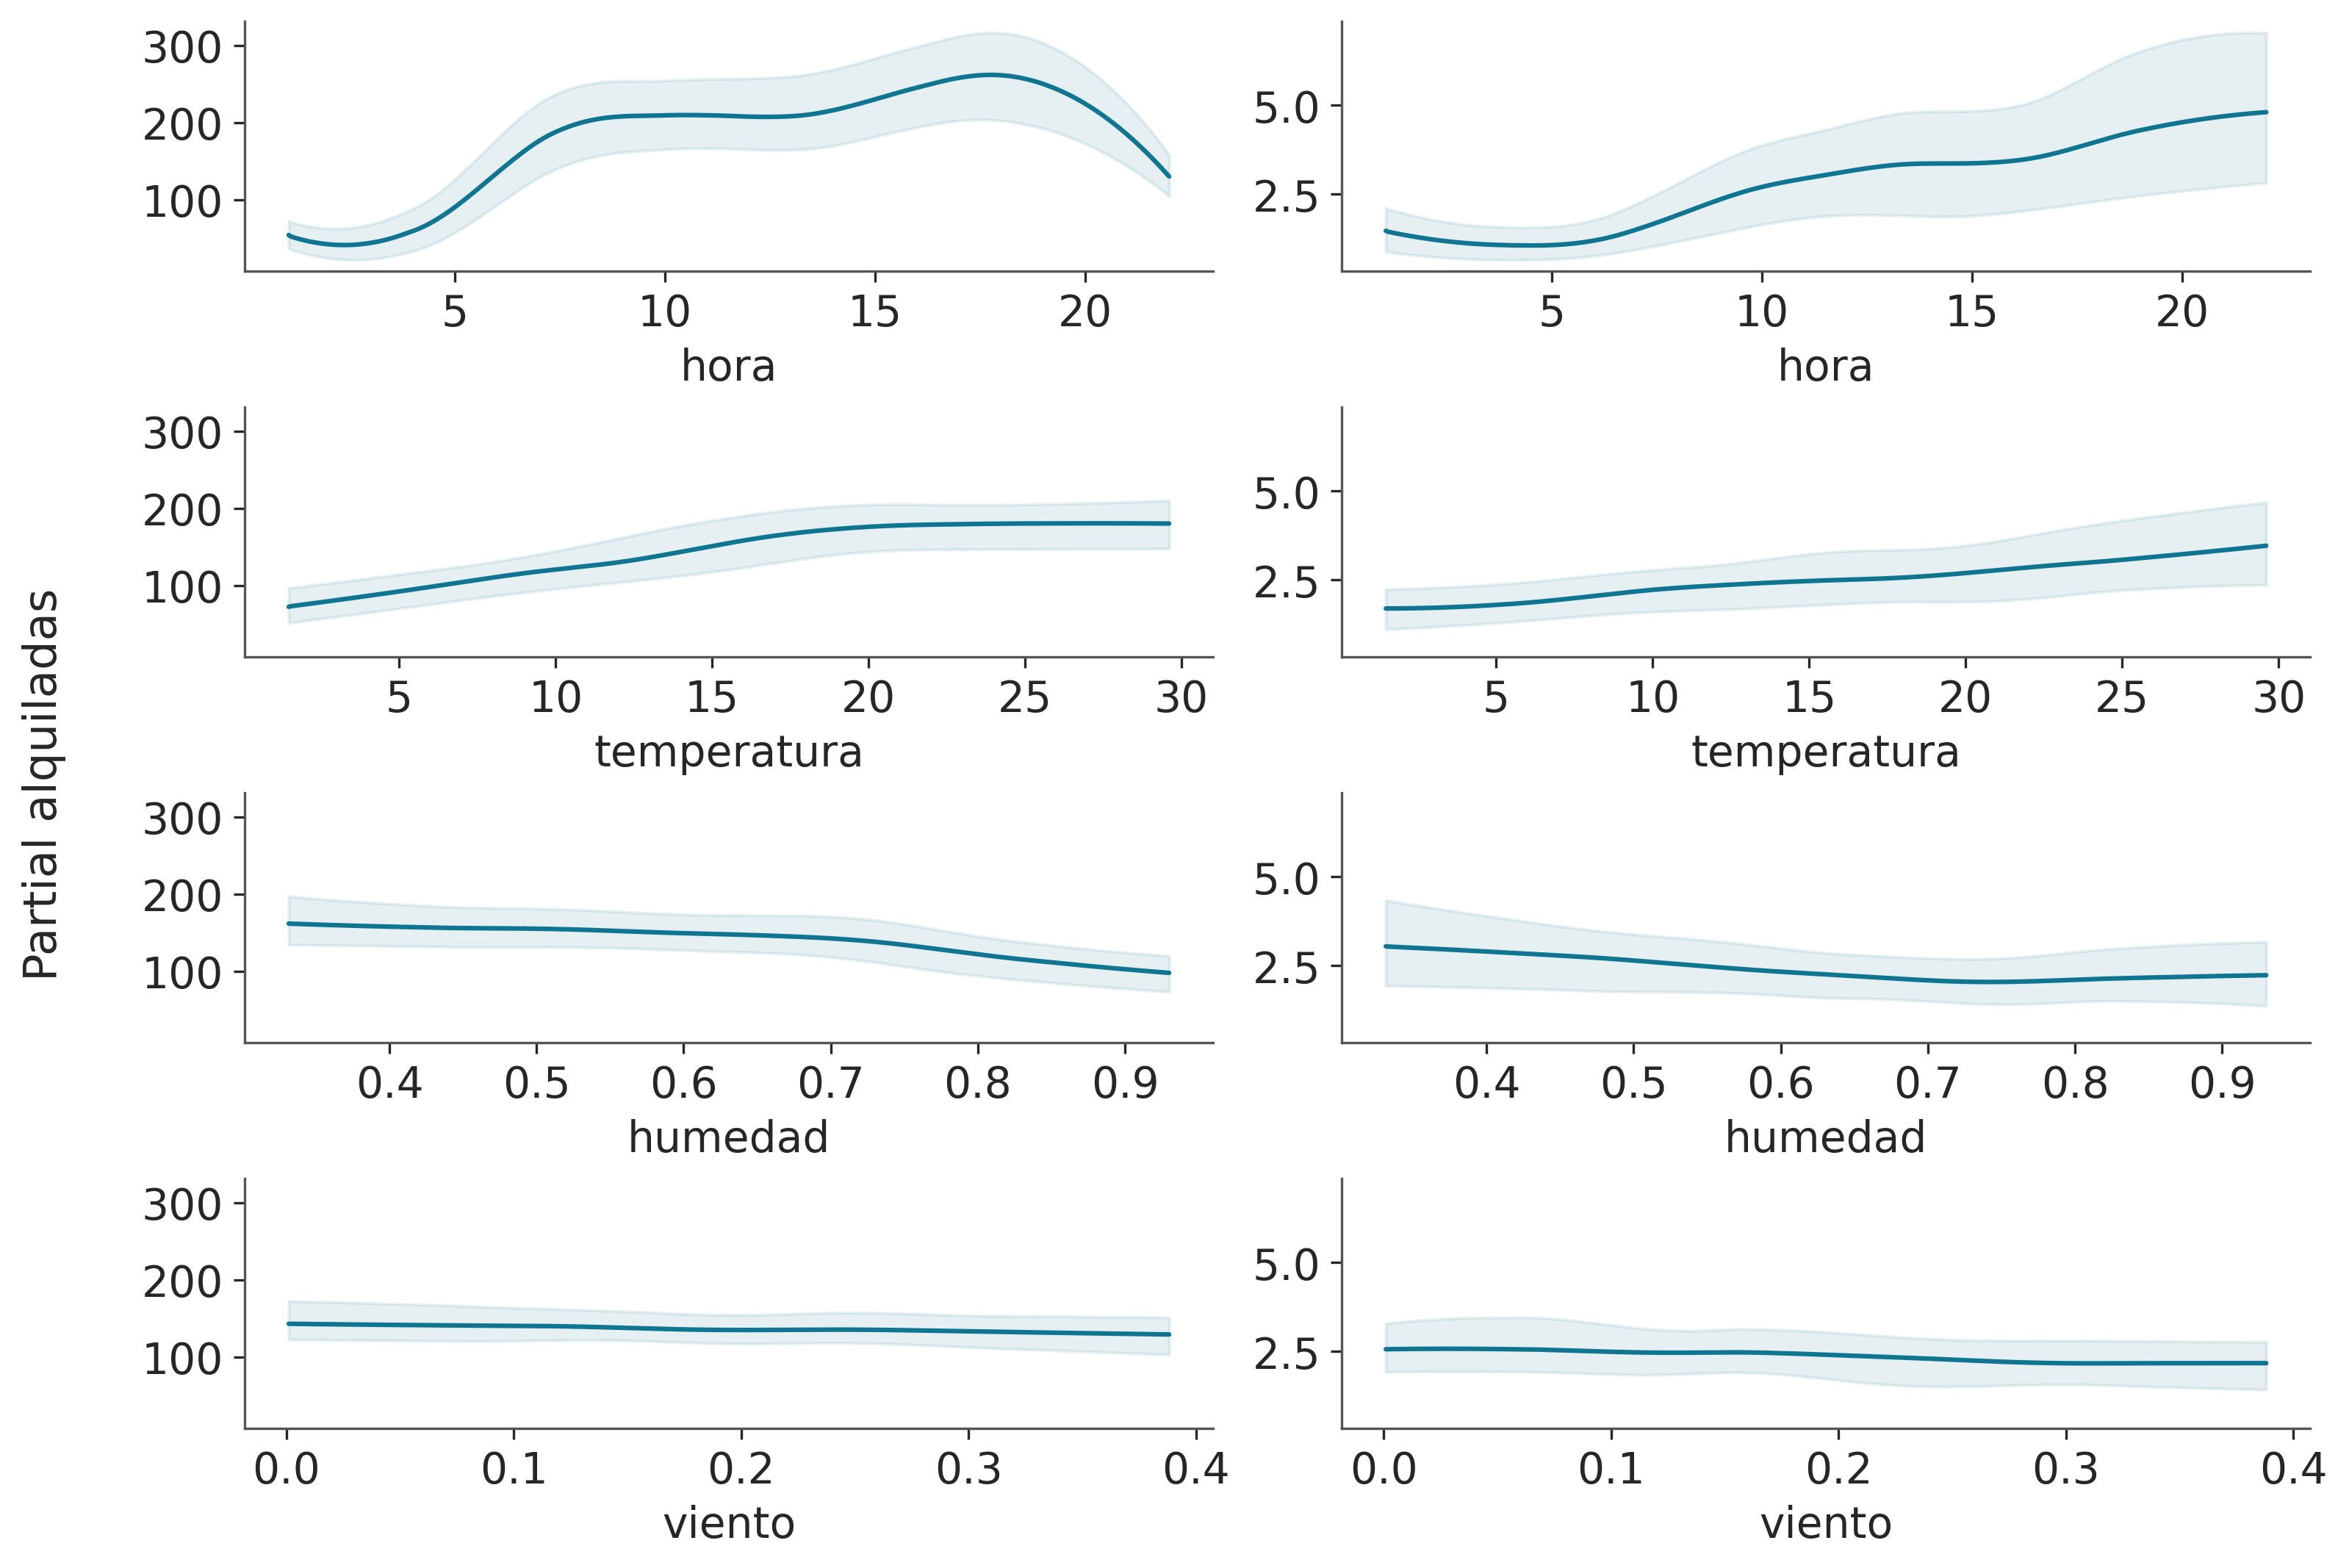

In [17]:
pmb.plot_pdp(μ, X, Y, func=np.exp, grid=(4, 2), sharey="col", figsize=(10, 7));

## PyMC-BART en el futuro

<br>
<br>

* Implementación en RUST --> incremento de la velocidad ~10x. Reducción del uso de memoria.
* Mayor flexibilidad para incorporar información previa, por ej restriccciones de monotonicidad 
* Otras métricas para evaluar la similitud de las predicciones en `plot_variable_importance`
* Mejores diagnósticos
* Mejor entendimiento de que modificar si la convergencia es "mala"
* Aplicaciones a series temporales
* ???

<br>
<br>